In [1]:
import gzip as gz
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True, precision=2)
pd.set_option('display.max_columns', 500)

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

from operator import add

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

22/12/09 12:47:39 WARN Utils: Your hostname, Antons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en5)
22/12/09 12:47:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 12:47:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data

Looking at the raw data

In [4]:
(
    spark.read.options(delimiter="\t")
    .csv("/Users/akusok/wrkdir/criteo/day_0_sample/part_0.gz")
    .limit(5)
    .toPandas()
)

22/12/09 12:49:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39
0,0,8,223,1,32,2,0,0,69,3,0,2,4707,1,265366bf,24caec4f,932ddfee,f2463ffb,c6fc10d3,6fcd6dcb,ad02a432,ab96c6b2,25dd8f9a,e63d98b4,c939136f,e3d4df3e,a77a4a56,None,eff53493,None,None,b8170bba,108a0699,47849e55,73b3f46d,d994ba60,None,760e09bc,321935cd,2ba8d787
1,0,1,38,None,None,None,None,0,5,0,None,None,13517,None,63e67382,97a91798,525811ca,f2463ffb,fcd84ac3,6fcd6dcb,eb692257,ac315d60,7cee8453,4267e2cb,6dda7ece,12716184,e07cc34d,be4ee537,d4c60724,4cdc3efa,d20856aa,b8170bba,9512c20b,0d960318,399fd66f,d660281b,15992145,21db0004,30436bfc,ed10571d
2,0,9,6,14,22,3,16,1,28,13,1,1,30,14,a97d405b,31183454,af84cf44,b0c5e548,8884f6ae,6fcd6dcb,a2e8808c,038e402d,2e4e821f,7f4cef0b,c105c127,1ce0bd3f,f4fc3c5e,None,6d7cfde6,None,None,b8170bba,9512c20b,a466e33d,4f310910,0e5f8d91,None,99c2f4d8,30436bfc,2ccea557
3,0,None,902,2,5,67,8,0,14,45,1,18,105,2,265366bf,d0bb2640,fe54dcfd,386c49ee,e755064d,6fcd6dcb,d935d694,d4612c5c,54fc547f,e63d98b4,c939136f,8c1feb42,26bb0b02,None,08527e4c,None,None,b8170bba,9512c20b,47849e55,73b3f46d,d994ba60,None,118885ac,337b81aa,b757e957
4,0,None,None,None,4,2,None,None,-1,0,None,2,43869,None,1ddd5ac8,f2817b18,0d233bc8,3bf96b51,c6fc10d3,6fcd6dcb,10bced43,7b7db213,25dd8f9a,7a4c3e4a,573186f5,12716184,e07cc34d,None,66c05256,None,None,b8170bba,9512c20b,8270d1db,e154fe46,54567163,None,8723c359,321935cd,b757e957


#### Load training data

Read known data fields with a schema

In [5]:
# loaded from auto-detect schema
schema = StructType([
    StructField('y', IntegerType(), True), 
    StructField('x1', IntegerType(), True), 
    StructField('x2', IntegerType(), True), 
    StructField('x3', IntegerType(), True), 
    StructField('x4', IntegerType(), True), 
    StructField('x5', IntegerType(), True), 
    StructField('x6', IntegerType(), True), 
    StructField('x7', IntegerType(), True), 
    StructField('x8', IntegerType(), True), 
    StructField('x9', IntegerType(), True), 
    StructField('x10', IntegerType(), True), 
    StructField('x11', IntegerType(), True), 
    StructField('x12', IntegerType(), True), 
    StructField('x13', IntegerType(), True), 
])

In [6]:
df_data = spark.read.options(delimiter="\t").csv("/Users/akusok/wrkdir/criteo/day_0_sample", schema=schema)

df_data.show()

+---+----+----+----+----+----+----+---+---+---+----+----+------+----+
|  y|  x1|  x2|  x3|  x4|  x5|  x6| x7| x8| x9| x10| x11|   x12| x13|
+---+----+----+----+----+----+----+---+---+---+----+----+------+----+
|  0|   2| 190|   2|null|null|   0|  0|116|  0|   0|null|388772|   2|
|  0|   5|1030|   0|  74|   3|   0|  0|  7| 39|   0|   3|   475|  33|
|  0|  77|2083|   8|null|null|   0|  0| 17|  6|   0|null|  4973|  35|
|  0|  33| 403|  12|  36|   5|   0|  0| 22| 12|   0|   3|  5122|  12|
|  0|  37|   1|  15|null|null|   0|  0| 49|  0|   0|null|    69|  22|
|  0|   3| 217|   1|null|  18|   0|  0|  3|  0|   0|   3| 16557|   1|
|  0|   5|  33|null|null|null|null|  0|  0|  0|null|null|  4776|null|
|  0|   7| 124|   1|null|null|   0|  0| 15|  7|   0|null|  1501|   1|
|  0|   1|  23|   5|null|null|   2|  0|  1|  5|   1|null|   917|   5|
|  0|   3| 237|   2|null|  12|   0|  0|418|  0|   0|   7|  8507|   2|
|  0|   1|null|null|null|null|   0|  0|  1|  5|   0|null|   590|null|
|  0|  28|null|   6|

In [7]:
f"Data has {df_data.count() / 1e6} millions of rows"

'Data has 1.567143 millions of rows'

In [8]:
df_data.groupby("y").agg(F.count("*")).show()

+---+--------+
|  y|count(1)|
+---+--------+
|  1|   50446|
|  0| 1516697|
+---+--------+



## Setup

In [9]:
d = 13  # number of features in X
num_out = 1  # number of features in Y

l = 100  # number of hidden neurons

In [10]:
batch_N = 5000
batch_l = 65

In [11]:
W = np.random.randn(d, l-1)
W = np.hstack([ W, np.zeros((W.shape[0], 1)) ])  # zero-neuron that adds bias

# bias constant
b = np.zeros((1, l))
b[0, -1] = 1

In [12]:
W.shape, b.shape

((13, 100), (1, 100))

Broadcast ELM random weights to Spark

In [13]:
# condition check removes the last empty batch when W divides by batch size equally
split_idx = [batch_l*(i+1) for i in range(l // batch_l) if batch_l*(i+1) < l]
l_blocks = len(split_idx) + 1

# split W and bias at once
Wb = [(wb, bias_b) for wb,bias_b in zip(
    np.array_split(W, split_idx, axis=1),
    np.array_split(b, split_idx, axis=1)
)]

In [14]:
spWb = sc.parallelize(enumerate(Wb))
spW2 = sc.broadcast(spWb.cartesian(spWb).collect())

# for H'Y computation
spW0 = sc.broadcast(W)
spb0 = sc.broadcast(b)

## Process a bunch of Numpy arrays into chunks of HH arrays

## _PYSPARK_

In [15]:
def compute(buffer):
    data0 = pd.DataFrame(buffer).fillna(-1).to_numpy().astype(int)
    y0 = data0[:, :num_out]  # first `num_out` data columns belong to Y, rest to X
    x0 = data0[:, num_out:]

    for w in spW2.value:
        i, (w1, b1) = w[0]
        j, (w2, b2) = w[1]

        if j < i:
            yield ((i, j), (0, 0))  # format is  [ (HtH block coordinates), (HtH, HtY) ]
        else:            
            if i == 0 and j == 0:
                # report HtY once per batch
                yield (
                    (i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), np.tanh(x0@spW0.value + spb0.value).T @ y0))
            else:
                # Qb = (f(X0@Wb1) + bb1).T @ (f(X0@Wb2) + bb2)
                yield ((i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), 0))

In [16]:
def process_partition(data):
    buf = []
    
    for d in data:
        buf.append(d)
        if len(buf) >= batch_N:
            yield from compute(buf)
            buf = []
            
    if len(buf) > 0:
        yield from compute(buf)

Define computational graph here - nothing runs yet

In [17]:
spBlocks = (
    df_data.rdd.map(np.array)
    .mapPartitions(process_partition)
    .foldByKey((0, 0), lambda a,b: (a[0]+b[0], a[1]+b[1]))
)

## Request data to trigger computations

In [18]:
%%time

# prepare empty block matrix storage
HtH_blocks = [[ [] for _ in range(l_blocks)  ] for _ in range(l_blocks)]
HtY = 0

# gather data into block matrix
for (i, j), (HtH_part, HtY_part) in spBlocks.collect():
    HtH_blocks[i][j] = HtH_part
    HtY += HtY_part

# fill missing triangular part
for i in range(l_blocks):
    for j in range(l_blocks):
        if j > i:
            HtH_blocks[j][i] = HtH_blocks[i][j].T

HtH = np.block(HtH_blocks)
HtH.shape, HtY.shape

CPU times: user 14.1 ms, sys: 7.18 ms, total: 21.3 ms
Wall time: 21.6 s


((100, 100), (100, 1))

In [19]:
HtH[-1,-1]

1567143.0

## Compute ELM output weights

In [20]:
from scipy.linalg import lstsq

In [31]:
# add L2-regularization to the diagonal to HtH
B = lstsq(HtH + 1e+1 * np.eye(HtH.shape[0]), HtY)[0]
B.shape

(100, 1)

## Test with another file

In [33]:
df_test = spark.read.options(delimiter="\t").csv("/Users/akusok/wrkdir/criteo/day_0/part_20.gz", schema=schema)

df_test.show(5)

+---+---+----+----+----+----+----+---+---+---+----+----+-----+----+
|  y| x1|  x2|  x3|  x4|  x5|  x6| x7| x8| x9| x10| x11|  x12| x13|
+---+---+----+----+----+----+----+---+---+---+----+----+-----+----+
|  0| 29| 285|   6|  93|  19|   0|  0|  4|  4|   0|   4|  879|  16|
|  0|  3|null|   3|null|null|   0|  0|  3|  3|   0|null| 2010|   3|
|  0|  3| 397|   1|null|   1|   0|  0| 16| 12|   0|   1|20721|   6|
|  0|  1| 182|null|null|null|   0|  0|  1| 18|   0|null| 7248|null|
|  0|  1| 523|null|null|   2|null|  0|  0|  0|null|   1| 7414|null|
+---+---+----+----+----+----+----+---+---+---+----+----+-----+----+
only showing top 5 rows



In [34]:
X_test = df_test.toPandas().fillna(-1).iloc[:, 1:].to_numpy()
Y_test = df_test.toPandas().fillna(-1).iloc[:, 0].to_numpy()

In [35]:
Y_score = np.tanh(X_test @ W + b) @ B

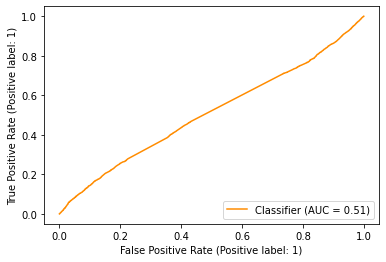

In [36]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    Y_test,
    Y_score,
    color="darkorange",
)